# Classic Risk Premia Portfolio Backtest

In this notebook we backtest a classic long-only portfolio of ETFs.

Profits are re-invested.

Rebalancing occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended.

Contrast with a percentage commission scheme where trading back to the buffer limit only is considered optimal.

In [2]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

import ffn

%matplotlib inline

# Hack to ensure the notebook can load local modules by appending the parent directory to the system path
# Ensure a '.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

import alphasim.backtest
importlib.reload(alphasim.backtest)

from alphasim.backtest import backtest

In [3]:
price_df = pdr.get_data_yahoo(['VTI', 'TLT', 'GLD'])
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2017-10-09,120.264023,111.911865,122.080002
2017-10-10,120.548782,112.092422,122.400002
2017-10-11,120.714096,112.309052,122.790001
2017-10-12,120.567154,112.787460,122.889999
2017-10-13,120.658981,113.599838,123.820000
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


In [4]:
weight_df = price_df.copy()
weight_df[:] = [0.6, 0.3, 0.1]
display(weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2017-10-09,0.6,0.3,0.1
2017-10-10,0.6,0.3,0.1
2017-10-11,0.6,0.3,0.1
2017-10-12,0.6,0.3,0.1
2017-10-13,0.6,0.3,0.1
...,...,...,...
2022-10-03,0.6,0.3,0.1
2022-10-04,0.6,0.3,0.1
2022-10-05,0.6,0.3,0.1


In [5]:
def fixed_min_commission(trade_price, trade_size):
    return 10

result = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result)

price start_portfolio     exposure current_weight  \
datetime   Symbols                                                           
2017-10-09 VTI      120.264023             0.0          0.0            0.0   
           TLT      111.911865             0.0          0.0            0.0   
           GLD      122.080002             0.0          0.0            0.0   
           cash       1.000000           10000      10000.0            1.0   
2017-10-10 VTI      120.548782       49.890232  6014.206719       0.601922   
...                        ...             ...          ...            ...   
2022-10-06 cash       1.000000      672.530201   672.530201        0.05009   
2022-10-07 VTI      184.570007       41.932929  7739.561014       0.584277   
           TLT      100.920998       35.032522   3535.51708       0.266904   
           GLD      158.554993         8.19135  1298.779409       0.098048   
           cash       1.000000      672.530201   672.530201       0.050771   

                    target_weight delta_weight  do_trade adj_target_weight  \
datetime   Symbols                                                           
2017-10-09 VTI       6.000000e-01          0.6      True               0.6   
           TLT       3.000000e-01          0.3      True               0.3   
           GLD       1.000000e-01          0.1      True               0.1   
           cash      1.110223e-16         -1.0     False               1.0   
2017-10-10 VTI       6.000000e-01    -0.001922     False          0.601922   
...                           ...          ...       ...               ...   
2022-10-06 cash      1.110223e-16     -0.05009     False           0.05009   
2022-10-07 VTI       6.000000e-01     0.015723     False          0.584277   
           TLT       3.000000e-01     0.033096     False          0.266904   
           GLD       1.000000e-01     0.001952     False          0.098048   
           cash      1.110223e-16    -0.050771     False          0.050771   

                   adj_delta_weight trade_value trade_size end_portfolio  
datetime   Symbols                                                        
2017-10-09 VTI                  0.6      6000.0  49.890232     49.890232  
           TLT                  0.3      3000.0  26.806809     26.806809  
           GLD                  0.1      1000.0    8.19135       8.19135  
           cash                 0.0         0.0        0.0         -30.0  
2017-10-10 VTI                  0.0         0.0        0.0     49.890232  
...                             ...         ...        ...           ...  
2022-10-06 cash                 0.0         0.0        0.0    672.530201  
2022-10-07 VTI                  0.0         0.0        0.0     41.932929  
           TLT                  0.0         0.0        0.0     35.032522  
           GLD                  0.0         0.0        0.0       8.19135  
           cash                 0.0         0.0        0.0    672.530201  

[5036 rows x 12 columns]

In [6]:
trades_df = result.loc[result['do_trade'] == True]
display(len(trades_df))
display(trades_df)

16

price start_portfolio     exposure current_weight  \
datetime   Symbols                                                           
2017-10-09 VTI      120.264023             0.0          0.0            0.0   
           TLT      111.911865             0.0          0.0            0.0   
           GLD      122.080002             0.0          0.0            0.0   
2018-08-07 VTI      137.197174       49.890232  6844.798844       0.640454   
2018-12-20 VTI      117.989235       46.738907  5514.687837        0.55683   
2020-03-09 VTI      132.790451       50.362485  6687.657051       0.542216   
           TLT      164.092453       26.806809  4398.795052       0.356642   
2020-03-23 VTI      107.296585       55.729634   5979.59942       0.559646   
2020-04-08 VTI      131.812042       59.748138  7875.524117       0.645891   
2020-06-04 TLT      151.230606       22.549371  3410.155061       0.258305   
2020-06-05 VTI      155.996826       55.502953   8658.28454       0.648383   
2021-01-05 TLT      151.548309       26.189268  3968.939357       0.259987   
2021-01-06 VTI      190.445480       51.361257  9781.519254       0.642472   
2021-03-12 VTI      202.389786       47.965876  9707.803393       0.640969   
2021-04-27 TLT      134.866837       30.219948  4075.668833       0.258788   
2022-09-12 VTI      205.776382       44.900042   9239.36825       0.642455   

                    target_weight delta_weight  do_trade adj_target_weight  \
datetime   Symbols                                                           
2017-10-09 VTI                0.6          0.6      True               0.6   
           TLT                0.3          0.3      True               0.3   
           GLD                0.1          0.1      True               0.1   
2018-08-07 VTI                0.6    -0.040454      True               0.6   
2018-12-20 VTI                0.6      0.04317      True               0.6   
2020-03-09 VTI                0.6     0.057784      True               0.6   
           TLT                0.3    -0.056642      True               0.3   
2020-03-23 VTI                0.6     0.040354      True               0.6   
2020-04-08 VTI                0.6    -0.045891      True               0.6   
2020-06-04 TLT                0.3     0.041695      True               0.3   
2020-06-05 VTI                0.6    -0.048383      True               0.6   
2021-01-05 TLT                0.3     0.040013      True               0.3   
2021-01-06 VTI                0.6    -0.042472      True               0.6   
2021-03-12 VTI                0.6    -0.040969      True               0.6   
2021-04-27 TLT                0.3     0.041212      True               0.3   
2022-09-12 VTI                0.6    -0.042455      True               0.6   

                   adj_delta_weight trade_value trade_size end_portfolio  
datetime   Symbols                                                        
2017-10-09 VTI                  0.6      6000.0  49.890232     49.890232  
           TLT                  0.3      3000.0  26.806809     26.806809  
           GLD                  0.1      1000.0    8.19135       8.19135  
2018-08-07 VTI            -0.040454 -432.352933  -3.151325     46.738907  
2018-12-20 VTI              0.04317  427.543195   3.623578     50.362485  
2020-03-09 VTI             0.057784   712.70619   5.367149     55.729634  
           TLT            -0.056642 -698.613431  -4.257438     22.549371  
2020-03-23 VTI             0.040354  431.171774   4.018504     59.748138  
2020-04-08 VTI            -0.045891 -559.566507  -4.245185     55.502953  
2020-06-04 TLT             0.041695  550.463881   3.639897     26.189268  
2020-06-05 VTI            -0.048383 -646.091466  -4.141696     51.361257  
2021-01-05 TLT             0.040013  610.842721    4.03068     30.219948  
2021-01-06 VTI            -0.042472 -646.634935  -3.395381     47.965876  
2021-03-12 VTI            -0.040969 -620.493476  -3.065834     44.900042  
2021-04-27 TLT 

In [7]:
pnl_df = result['exposure'].astype('float').groupby(['datetime']).sum().to_frame()
ret_df = np.log(pnl_df/pnl_df.shift(1)).dropna()
cumret_df = ret_df.cumsum()
vola_df = ret_df.ewm(alpha=1.-0.94, adjust=False).std() * np.sqrt(252)

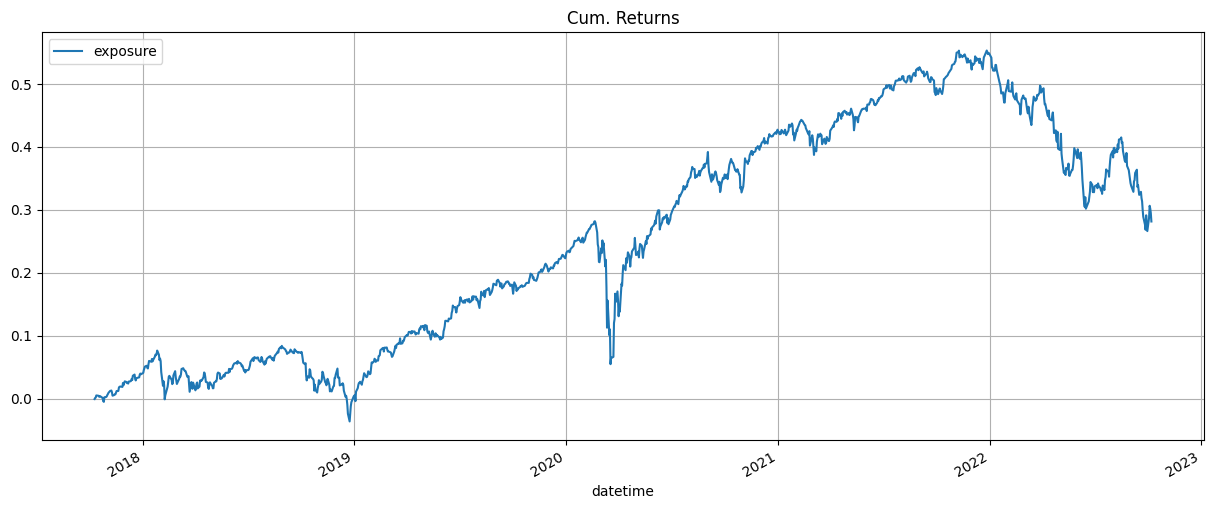

In [8]:
ax = cumret_df.plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Returns')
plt.legend(loc=2)
plt.show()

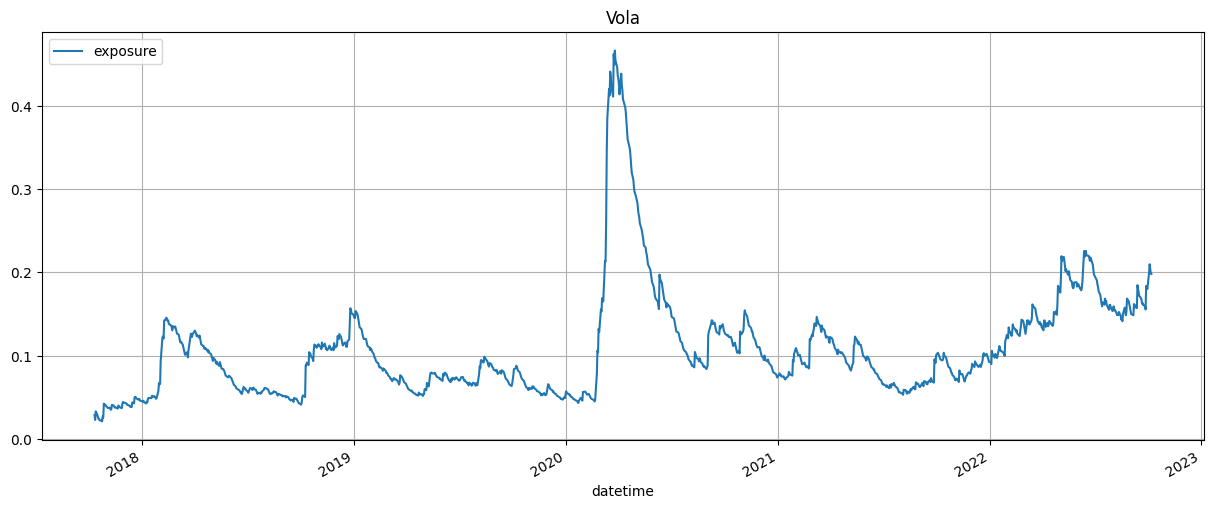

In [9]:
ax = vola_df.plot(figsize=(15, 6))
ax.grid(True)
plt.title('Vola')
plt.legend(loc=2)
plt.show()

Stat                 exposure
-------------------  ----------
Start                2017-10-09
End                  2022-10-07
Risk-free rate       0.00%

Total Return         32.46%
Daily Sharpe         0.50
Daily Sortino        0.75
CAGR                 5.79%
Max Drawdown         -24.93%
Calmar Ratio         0.23

MTD                  1.54%
3m                   -5.87%
6m                   -17.03%
YTD                  -23.43%
1Y                   -19.04%
3Y (ann.)            3.47%
5Y (ann.)            5.79%
10Y (ann.)           -
Since Incep. (ann.)  5.79%

Daily Sharpe         0.50
Daily Sortino        0.75
Daily Mean (ann.)    6.46%
Daily Vol (ann.)     12.82%
Daily Skew           -0.76
Daily Kurt           10.59
Best Day             5.52%
Worst Day            -6.25%

Monthly Sharpe       0.52
Monthly Sortino      0.87
Monthly Mean (ann.)  6.30%
Monthly Vol (ann.)   12.21%
Monthly Skew         -0.37
Monthly Kurt         0.39
Best Month           9.07%
Worst Month          -8.53%

Yea

<AxesSubplot: xlabel='datetime'>

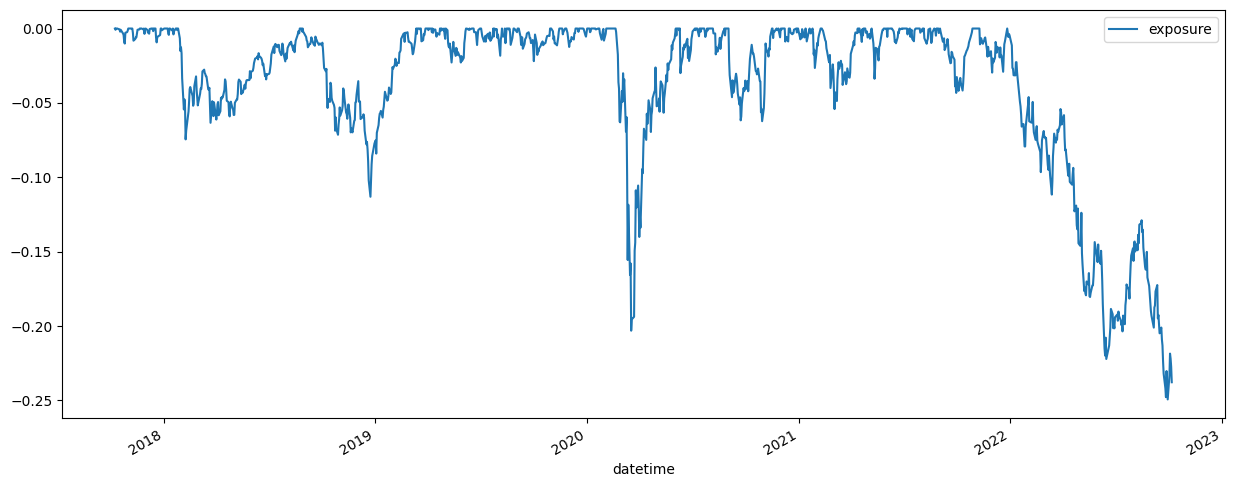

In [10]:
stats = pnl_df.calc_stats()
stats.display()
stats.prices.to_drawdown_series().plot(figsize=(15,6))